In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn.metrics import classification_report

# Notebook settings
from IPython.core.display import HTML

HTML("""
<style>
.container {
    width: 60% !important;
}
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Some useful functions for plotting data and decision regions

In [29]:
markers = ('o', 'x', 'o', '^', 'v')
colors = ('orange', 'blue', 'lightgreen', 'gray', 'cyan')

def plot_decision_regions(X, y, classifier, ax, shift=0.5, test_idx=None, resolution=0.02, fontsize=16):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('orange', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:,0].min()-shift, X[:,0].max()+shift
    x2_min, x2_max = X[:,1].min()-shift, X[:,1].max()+shift
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y==cl,0],
                   y=X[y==cl,1], 
                   alpha=0.8, 
                   marker=markers[idx], 
                   c=colors[idx],
                   label=cl, 
                   edgecolor='black')

    if test_idx:
        X_test = X[test_idx, :]
        ax.scatter(X_test[:, 0], 
                   X_test[:, 1],
                   c='', 
                   edgecolor='black', 
                   alpha=1.0,
                   linewidth=0.5, 
                   marker='o',
                   s=10, 
                   label='test set')
        
        
    ax.tick_params(which='major', axis='both', labelsize=0.75*fontsize)
    ax.set_xlabel("var 1", fontsize=0.75*fontsize, fontweight='bold')
    ax.set_ylabel("var 2", fontsize=0.75*fontsize, fontweight='bold')
    ax.legend(loc="best", fontsize=0.75*fontsize)
        
def plot_data(X, y, title="data 1", fontsize=16):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    for i, lab in enumerate(np.unique(y)):
        ax.scatter(X[y==lab, 0], X[y==lab, 1], s=50, marker=markers[i], 
                   color=colors[i], label=lab, alpha=0.8)
    ax.tick_params(which='major', axis='both', labelsize=0.5*fontsize)
    ax.set_xlabel("var 1", fontsize=0.75*fontsize, fontweight='bold')
    ax.set_ylabel("var 2", fontsize=0.75*fontsize, fontweight='bold')
    ax.legend(loc="best", fontsize=0.75*fontsize)
    ax.set_title(title, fontweight="bold", fontsize=fontsize)
    plt.show(fig)

In [30]:
np.random.seed(1)

## Explore Data

In [31]:
data1 = pd.read_pickle('data1.pkl')
data2 = pd.read_pickle('data2.pkl')

Split data into feature and labels : 

In [32]:
# Data 1
X1 = data1[['f1', 'f2']].values
y1 = data1['label'].values

# Data 2
X2 = data2[['f1', 'f2']].values
y2 = data2['label'].values

In [33]:
print('Dataset 1')
print('\t Shape of X1 : ', X1.shape)
print('\t Shape of y1 : ', y1.shape)
print('=' * 40)
print('Dataset 2')
print('\t Shape of X2 : ', X2.shape)
print('\t Shape of y2 : ', y2.shape)

Dataset 1
	 Shape of X1 :  (51, 2)
	 Shape of y1 :  (51,)
Dataset 2
	 Shape of X2 :  (863, 2)
	 Shape of y2 :  (863,)


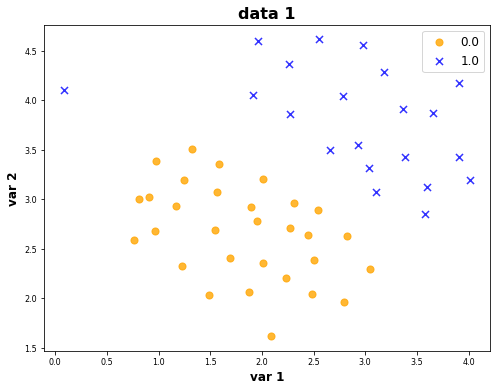

In [34]:
plot_data(X1, y1, title="data 1")

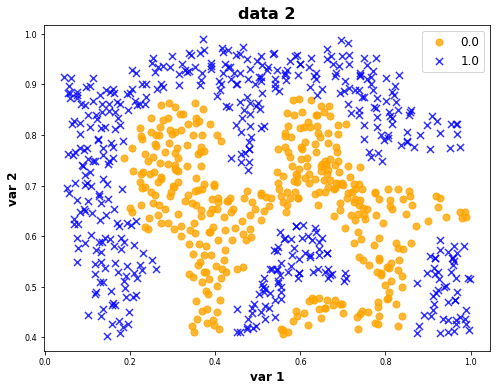

In [35]:
plot_data(X2, y2, title="data 2")

### Some python reminders : use of `*args` and `**kwargs`

In [36]:
def my_sum(a,b):
    return a+b

print(my_sum(1,2))

3


In [37]:
def my_sum(*args):
    print(type(args), args)
    result = 0
    # Iterating over the Python args tuple
    for x in args:
        result += x
    return result

print(my_sum(1,2))

<class 'tuple'> (1, 2)
3


In [38]:
def concatenate_string(**kwargs):
    print(type(kwargs), kwargs)
    result = ""
    # Iterating over the Python kwargs dictionary
    for arg in kwargs.values():
        result += arg
    return result

print(concatenate_string(a="Real", b="Python", c="Is", d="Great", e="!"))

<class 'dict'> {'a': 'Real', 'b': 'Python', 'c': 'Is', 'd': 'Great', 'e': '!'}
RealPythonIsGreat!


### A bit of Object-Oriented Programming

In [39]:
class CustomSVC():
    """
    Custom class to build a classifier using a sklearn.svm.SVC object 
    fitted with a precomputed kernel
    
    Attributes
    ----------
    C: float
        Regularization parameter for SVC
    func_kernel:
        The kernel function used to compute the kernel matrix
    args_kernel:
        Positional arguments for func_kernel
    kwargs_kernel:
        Keyword arguments for func_kernel
        
    Methods
    -------
    fit(self, X, y):
        Fit the internal SVC object
    predict(self, X):
        Make predictions on the raw data X using the kernel_func and the SVC
    """
    def __init__(self, C, func_kernel, *args_kernel, **kwargs_kernel):
        self.C = C
        self.func_kernel = func_kernel
        self.args_kernel = args_kernel
        self.kwargs_kernel = kwargs_kernel
        
    def _get_K(self, X1, X2):
        return self.func_kernel(X1, X2, *self.args_kernel, **self.kwargs_kernel)
        
    def fit(self, X, y):
        self._svc = SVC(C=self.C, kernel="precomputed")
        self._Xtrain = X
        self._svc = self._svc.fit(self._get_K(X,X), y)
        return self
        
    def predict(self, X):
        return self._svc.predict(self._get_K(X, self._Xtrain))

### Training a SVC for linear separation (Data 1)

**YOUR WORK**

In this part you have to implement a first kernel function that will separate linearly the data.

1. The first kernel function is the so-called **linear kernel** which computes the euclidean inner product between two real vectors.
    
__Instructions__

1. Implement the function `linear_kernel` that takes as input 2 matrices $X_1, X_2$ of sizes $(m,p), (n,p)$ and that output a matrix of pairwise kernel values $K$ of size $(m,n)$.
2. Try to avoid for loops that make the code much slower.

In [48]:
def linear_kernel(X1, X2):
    """ 
    Computes the linear kernel matrix between every row of X1 and every row of X2. 
    
    Parameters
    ----------
    X1: array-like, (m, p)
    X2: array-like, (n, p)
    
    Returns
    -------
    K: array-like, (m, n)
    """
    # YOUR CODE HERE
    K = X1.dot(X2.T)
    return K

Fit the SVC

In [41]:
linear_svc = CustomSVC(1, linear_kernel)
linear_svc = linear_svc.fit(X1, y1)

Plot decision boundary

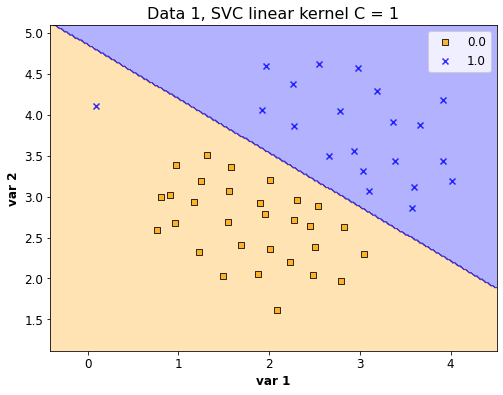

In [47]:
# Plot decision region
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
plot_decision_regions(X1, y1, linear_svc, ax=ax)
ax.set_title("Data 1, SVC linear kernel C = %.3g" % linear_svc.C, fontsize=16)
plt.show(fig)

In [78]:
pred = linear_svc.predict(X1)
print('Classification report on training Linear SVC for Data 1 (trainset)')
print(classification_report(y1, pred, labels=np.unique(y1)))

Classification report on training Linear SVC for Data 1 (trainset)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        21

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



We can see the second dataset is not linearly separable, thus we will need to use another kernel (gaussian kernel) for this SVM Classifier

### Training a SVC with Gaussian Kernel (Data 2)

**YOUR WORK**

In this part you have to implement a gaussian kernel function.
    
__Instructions__

1. The second kernel function is the **gaussian kernel** which computes the following distance between two real vectors 

    \begin{equation}
        K(x^i, x^j) = e^{-\gamma \|x^i - x^j\|^2}
    \end{equation}
    
    It depends on an extra parameter $\gamma$ that controls the peakedness of the kernel.
    You have to implement the `gaussian_kernel` function that takes as input 2 datasets $X_1$ $(m, p)$ and $X_2$ $(n, p)$ and returns the matrix of pairwise gaussian kernel values $(m, n)$
2. As for **linear kernel** try to avoid `for` loops that make the code much slower.

__Hint__ : For pairwise euclidian distance matrix you should use `scipy.spatial.distance.cdist` function for optimization purposes

In [49]:
from scipy.spatial.distance import cdist

In [60]:
def gaussian_kernel(X1, X2, gamma=1):
    """ 
    Computes the linear kernel matrix between every row of X1 and every row of X2. 
    
    Parameters
    ----------
    X1: array-like, (m, p)
    X2: array-like, (n, p)
    
    Returns
    -------
    K: array-like, (m, n)
    """
    # YOUR CODE HERE
    distance = cdist(X1, X2, 'euclidean')
    K = np.exp(- gamma * distance)
    return K

Fit SVC

In [85]:
C = 1e6
gamma = 1
gaussian_svc = CustomSVC(C, gaussian_kernel, gamma=1)
gaussian_svc = gaussian_svc.fit(X2, y2)

Plot decision boundary

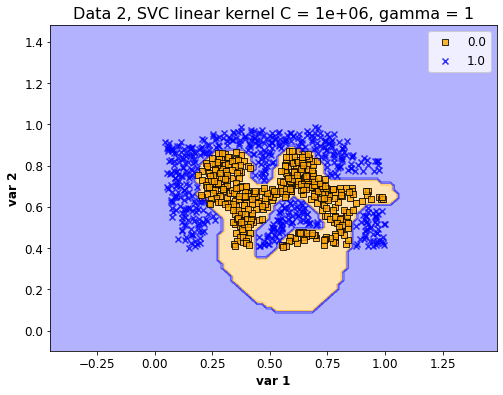

In [86]:
# Plot decision region
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
plot_decision_regions(X2, y2, gaussian_svc, ax=ax)
ax.set_title("Data 2, SVC linear kernel C = %.3g, gamma = %d" % (gaussian_svc.C, gaussian_svc.kwargs_kernel['gamma']), fontsize=16)
plt.show(fig)

In [87]:
pred_2 = gaussian_svc.predict(X2)
print('Classification report on training Linear SVC for Data 1 (trainset)')
print(classification_report(y2, pred_2, labels=np.unique(y2)))

Classification report on training Linear SVC for Data 1 (trainset)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       383
         1.0       1.00      1.00      1.00       480

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863



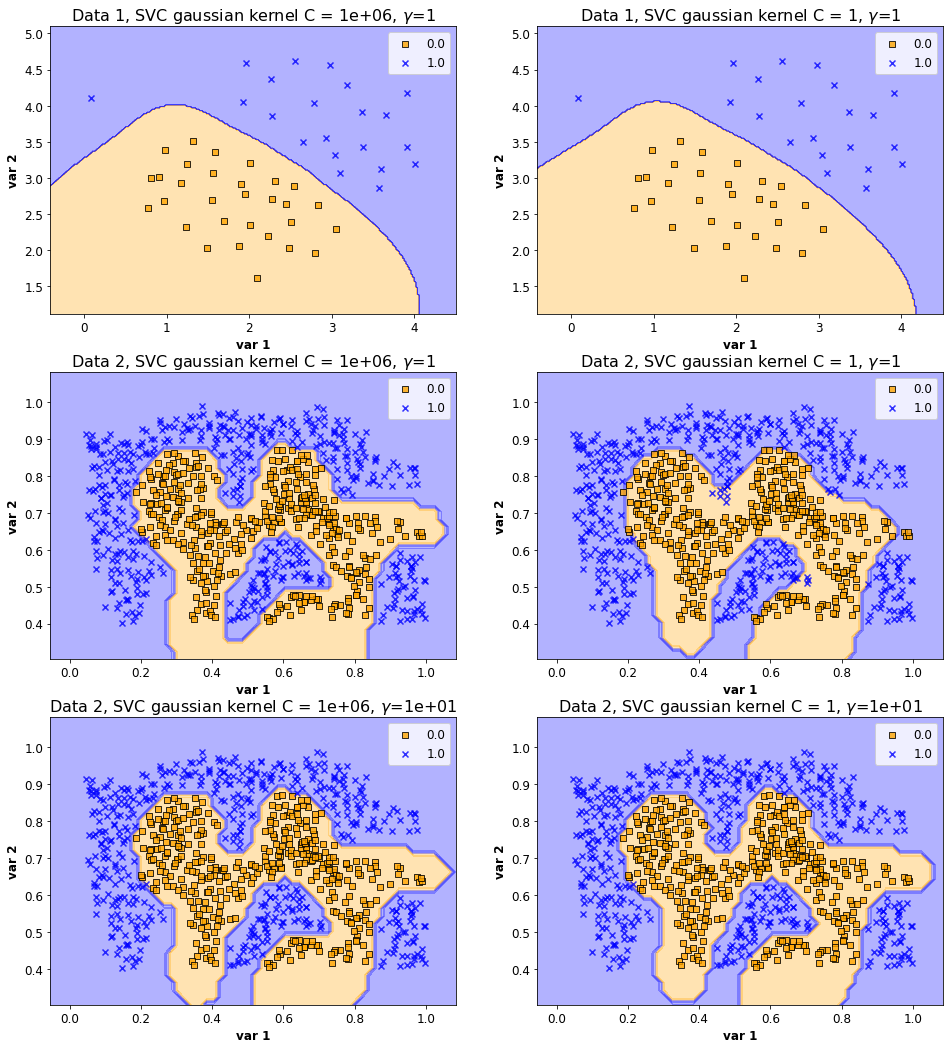

In [67]:
# Plot decision regions
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,18))
ax=ax.flatten()

for i, (C, gamma, data) in enumerate([(1e6,1,1), (1,1,1),
                                      (1e6,1,2), (1,1,2),
                                      (1e6,10,2), (1,10,2)]):

    if data==1:
        svc = CustomSVC(C=C, func_kernel=gaussian_kernel, gamma=gamma).fit(X1,y1)
        plot_decision_regions(X1, y1, svc, ax=ax[i])
    elif data==2:
        svc = CustomSVC(C=C, func_kernel=gaussian_kernel, gamma=gamma).fit(X2,y2)
        plot_decision_regions(X2, y2, svc, ax=ax[i], shift=0.1)
    ax[i].set_title(r"Data %d, SVC gaussian kernel C = %.1g, $\gamma$=%.1g" % (data, C, gamma), fontsize=16)

plt.show(fig)

### Grid Search Exploration for C and $\gamma$

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.20,
                                                    random_state=25)

param_grid = {"C": np.logspace(-3, 3, 30),
              "gamma": np.logspace(2, 4, 30)}

grid = GridSearchCV(estimator=SVC(kernel="rbf"),
                    param_grid=param_grid,
                    scoring="accuracy",
                    return_train_score=True,
                    refit=True,
                    cv=5, verbose=1, n_jobs=4)

grid = grid.fit(X_train, y_train)
print("best params %s" % grid.best_params_)
print("best score %.3f" % grid.best_score_)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 1232 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done 3232 tasks      | elapsed:   29.2s


best params {'C': 0.7880462815669912, 'gamma': 788.0462815669912}
best score 0.994


[Parallel(n_jobs=4)]: Done 4500 out of 4500 | elapsed:   39.8s finished


In [72]:
# performance
y_pred_train = grid.best_estimator_.predict(X_train)
y_pred_test = grid.best_estimator_.predict(X_test)

print("Classification report train ...")
print(classification_report(y_train, y_pred_train, labels=np.unique(y2)))

print("Classification report test ...")
print(classification_report(y_test, y_pred_test, labels=np.unique(y2)))

Classification report train ...
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       308
         1.0       1.00      1.00      1.00       382

    accuracy                           1.00       690
   macro avg       1.00      1.00      1.00       690
weighted avg       1.00      1.00      1.00       690

Classification report test ...
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        75
         1.0       1.00      1.00      1.00        98

    accuracy                           1.00       173
   macro avg       1.00      1.00      1.00       173
weighted avg       1.00      1.00      1.00       173



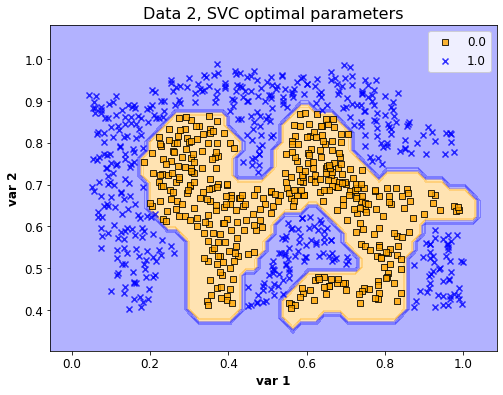

In [74]:
# Plot decision region
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

svc = SVC(kernel="rbf", gamma=grid.best_params_['gamma'], C=grid.best_params_["C"])
svc = svc.fit(X2, y2)
plot_decision_regions(X2, y2, svc, ax=ax, shift=0.1)
ax.set_title("Data 2, SVC optimal parameters", fontsize=16)

plt.show(fig)